In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import arange
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import shap
shap.initjs()
import warnings
warnings.simplefilter('ignore')

In [29]:
fao_data = pd.read_csv("~/Documents/Kaleb-Bsc thesis/Crop yield and agricultural practices/datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data
##fv

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [30]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals'],
      dtype=object)

In [31]:
shap_df = pd.DataFrame()

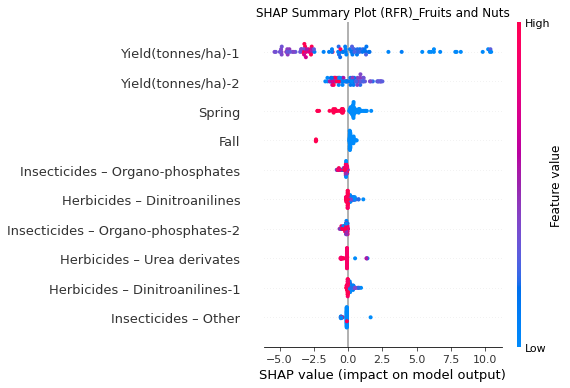

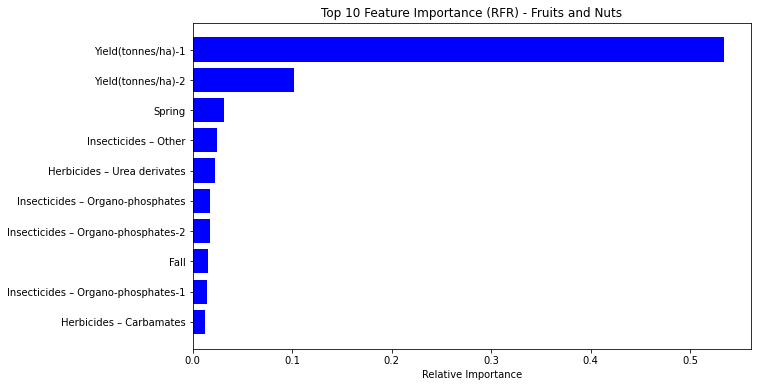

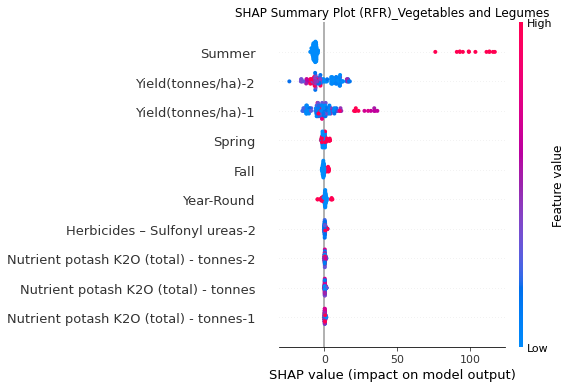

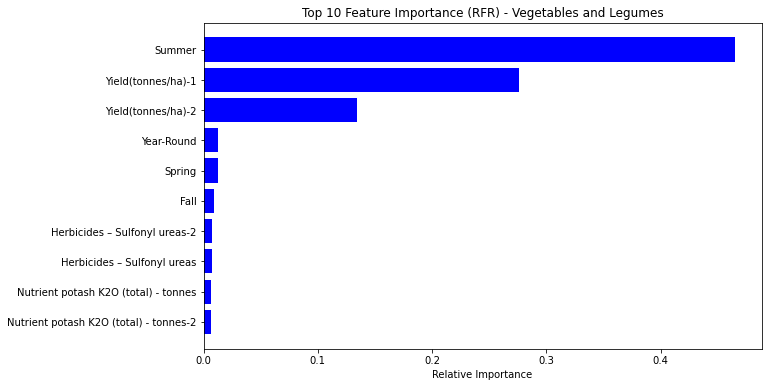

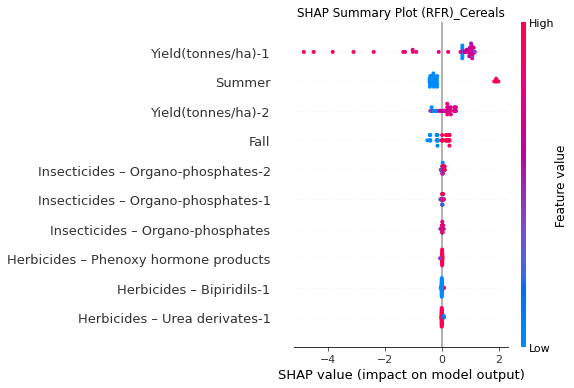

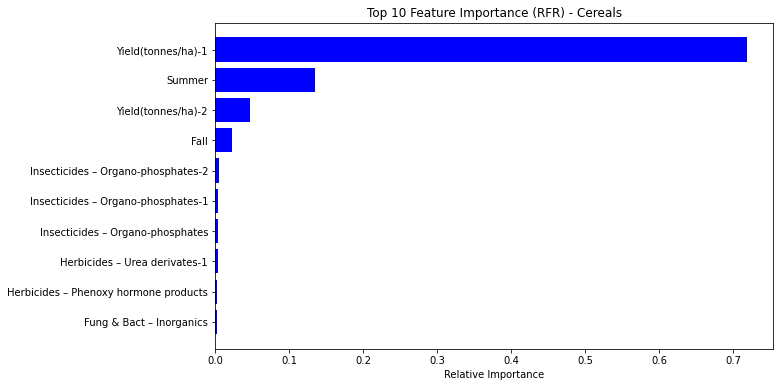

In [32]:
scaler = MinMaxScaler()
scaler_st = StandardScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')
    encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)
    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)



    
    regressor = RandomForestRegressor(n_estimators = 500, random_state = 42) #max_depth= 150)
    regressor.fit(x_train, y_train)
    
    #prediction of new value
    y_pred = regressor.predict(x_test)
    #shap implementation
    explainer = shap.TreeExplainer(regressor)
    shap_values = explainer.shap_values(x_test)
    explainer = shap.TreeExplainer(regressor)
    
    shap_values = explainer.shap_values(x_test)
    
    plt.title("SHAP Summary Plot (RFR)" + "_" + cat)
    shap.summary_plot(shap_values, x_test, max_display= 10)
    plt.show()
    shap_df_crop = pd.DataFrame(shap_values, columns=x_test.columns)
    shap_mean_crop = shap_df_crop.mean()
    shap_df[cat] = shap_mean_crop 
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[-10:]  # select the indices of top 10 features
    features = x_train.columns
    plt.figure(figsize=(10, 6))
    plt.title('Top 10 Feature Importance (RFR) - ' + cat)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show() 


In [33]:
shap_df['mean_shap_value'] = shap_df.mean(axis=1)
shap_df

,Fruits and Nuts,Vegetables and Legumes,Cereals,mean_shap_value
Nutrient nitrogen N (total) - tonnes,-0.005966,0.001532,0.001711,-0.000908
Nutrient phosphate P2O5 (total) - tonnes,-0.018401,0.003447,-0.000536,-0.005164
Nutrient potash K2O (total) - tonnes,-0.002567,0.405195,0.002564,0.135064
Fung & Bact – Benzimidazoles,-0.008542,0.001184,0.000895,-0.002154
"Fung & Bact – Diazines, morpholines",-0.002999,0.001930,0.000801,-0.000090
...,...,...,...,...
Rodenticides – Anti-coagulants-1,0.013140,0.024495,0.007312,0.014982
Rodenticides – Anti-coagulants-2,0.017558,0.027027,0.007013,0.017199
Fall,0.109829,-0.170800,-0.017355,-0.026108
Spring,0.101785,-0.228618,NaN,-0.063416


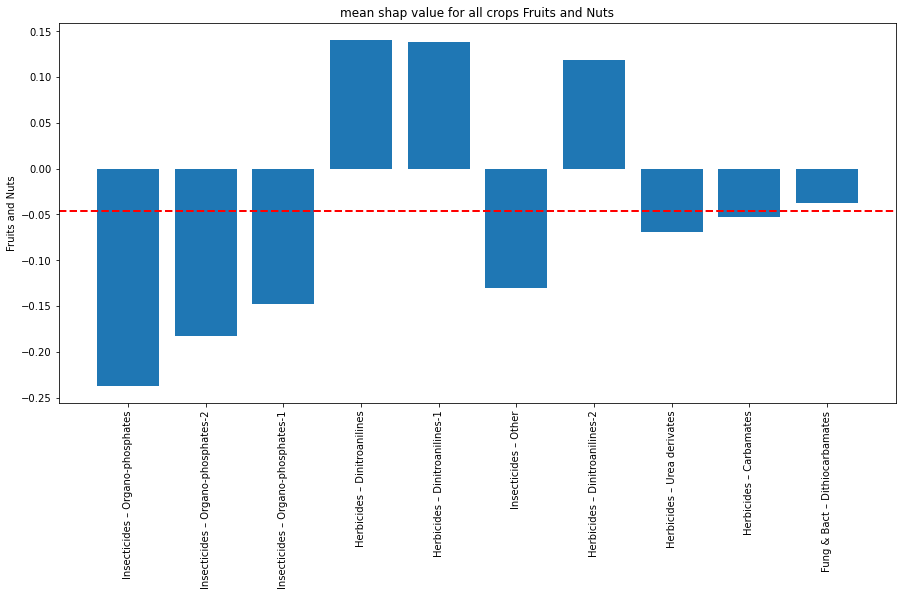

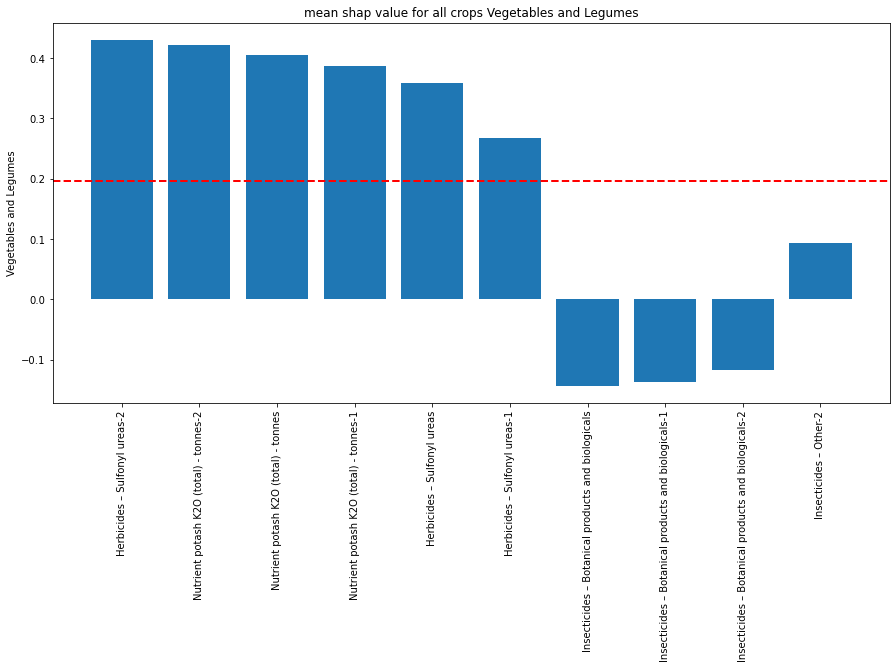

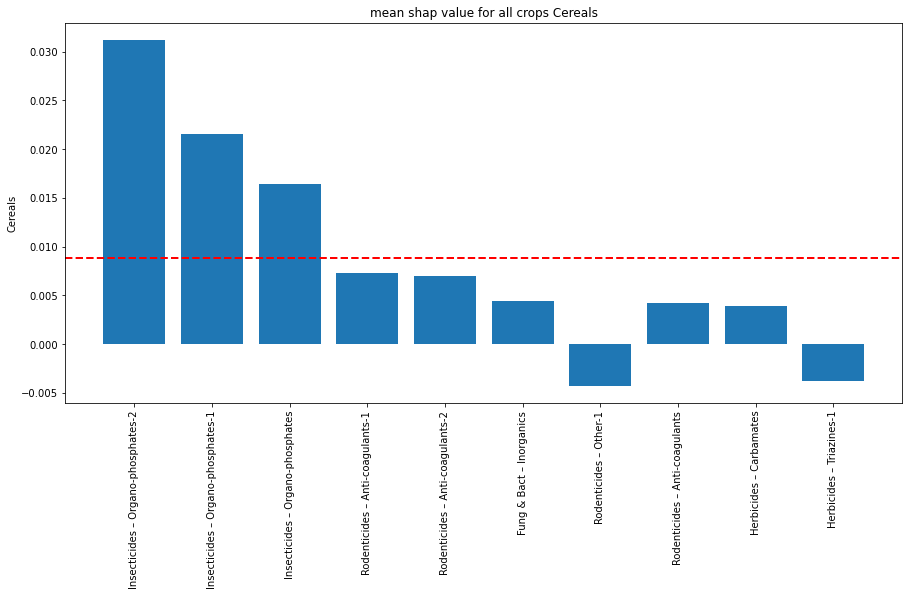

In [34]:
shap_rows = shap_df.index
shap_rows = shap_rows.drop(['Yield(tonnes/ha)-1', 'Yield(tonnes/ha)-2', 'Fall', 'Spring', 'Year-Round'])

for cat in cat_names:
    crop_df = pd.DataFrame(shap_df.loc[shap_rows][cat], columns=[cat])
    sorted_df = crop_df.reindex(crop_df[cat].abs().sort_values(ascending=False).index)

    top_10 = sorted_df.head(10)

    #sorted_means = sorted(mean_shap, key=abs, reverse=True)
    #top_values = sorted_means[:10]
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.bar(top_10.index, top_10[cat])
    ax.axhline(top_10[cat].mean(), color='red', linestyle='dashed', linewidth=2)
    ax.set_xticklabels(top_10.index, rotation=90)
    ax.set_ylabel(cat)
    ax.set_title('mean shap value for all crops ' + cat)
    plt.show()

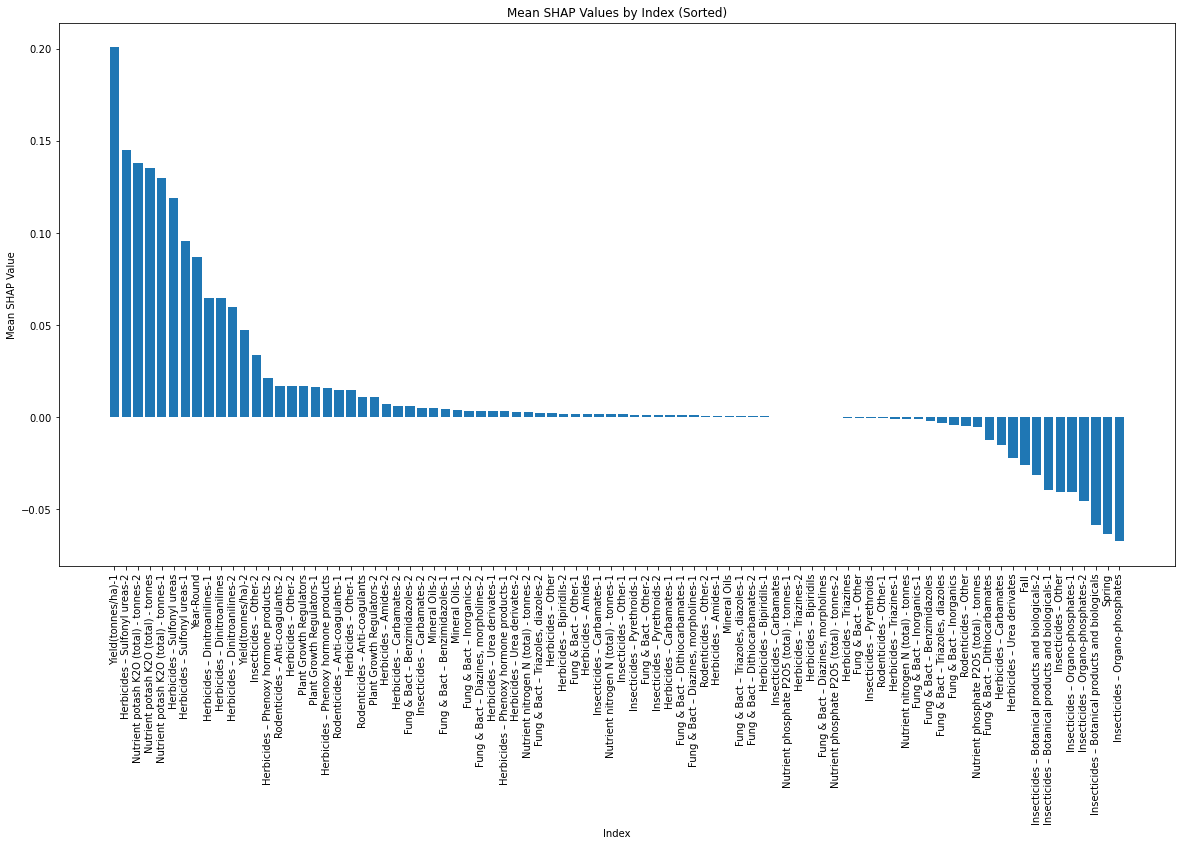

In [35]:
import matplotlib.pyplot as plt

# Sort the DataFrame by "mean_shap_value" column in descending order
shap_df_sorted = shap_df.sort_values(by='mean_shap_value', ascending=False)

# Extracting the index and mean SHAP values from the sorted DataFrame
index = shap_df_sorted.index
mean_shap_values = shap_df_sorted['mean_shap_value']

# Set the figure size
plt.figure(figsize=(20, 10))

# Creating the bar plot
plt.bar(index, mean_shap_values)

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Mean SHAP Value')
plt.title('Mean SHAP Values by Index (Sorted)')

# Rotating x-axis labels if needed
plt.xticks(rotation='vertical')

# Displaying the plot
plt.show()


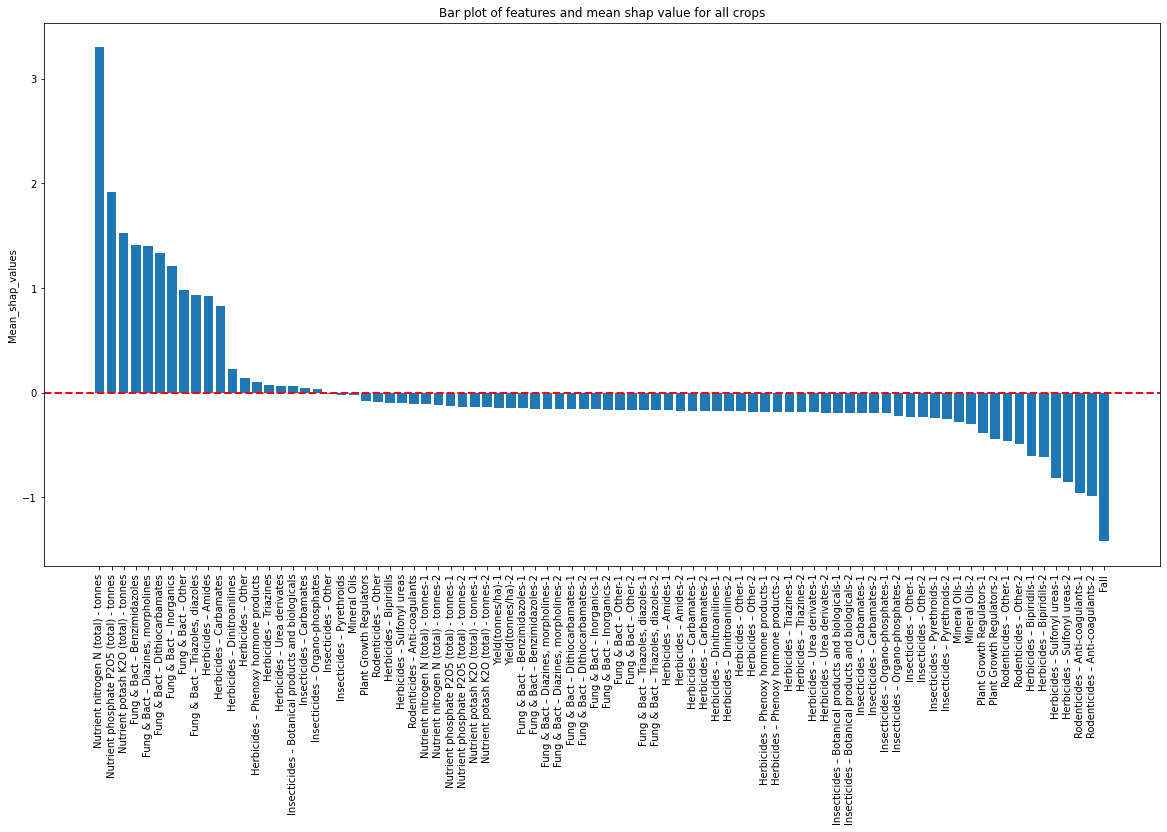

In [26]:
scaler = StandardScaler()
scaler.fit(shap_df)
shap_gen = pd.DataFrame(scaler.transform(shap_df), columns=shap_df.columns, index=shap_df.index)
shap_gen['mean_shap_value'] = shap_gen.mean(axis=1)
shap_gen = shap_gen.sort_values(by='mean_shap_value', ascending=False)
shap_gen = shap_gen.dropna()
mean_shap = shap_gen['mean_shap_value'].mean()
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(shap_gen.index, shap_gen['mean_shap_value'])
ax.axhline(mean_shap, color='red', linestyle='dashed', linewidth=2)
ax.set_xticklabels(x, rotation=90)
ax.set_ylabel('Mean_shap_values')
ax.set_title('Bar plot of features and mean shap value for all crops')
plt.show()